In [80]:
! pip install torch transformers seaborn scikit-learn pandas

^C
ERROR: Operation cancelled by user


In [1]:
import copy

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
from tqdm import tqdm

from styles import fig_size

sns.set_style('white')
sns.set_context('paper')
sns.set_palette('tab10')

/home/john/miniconda3/envs/ds/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ONS baby names 2021
df1 = pd.read_csv('data/baby_name_counts.csv')
df2 = pd.read_csv('data/baby_names.csv')
df = df2.join(df1)
df = df.dropna()
df


,Name,Counts
0,A,5.0
1,A-Jay,5.0
3,Aaban,4.0
5,Aadam,90.0
8,Aaden,5.0
...,...,...
16763,Zy'Aire,3.0
16767,Zyair,4.0
16768,Zyaire,14.0
16769,Zyan,19.0


# rank-counts of baby names in UK 2021

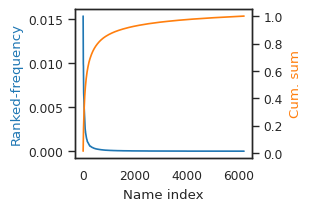

In [3]:
df_s = df.sort_values('Counts', ascending=False)

x = np.arange(len(df_s))
y = df_s.Counts.to_numpy() / df_s.Counts.sum()
y2 = np.cumsum(y)

import itertools

palette = itertools.cycle(sns.color_palette())
c1 = next(palette)
c2 = next(palette)

fig,ax = plt.subplots(figsize=(3, 2), constrained_layout=True)
#add first line to plot
ax.plot(x, y, color=c1)
#add x-axis label
plt.xlabel('Name index')
#add y-axis label
ax.set_ylabel('Ranked-frequency', color=c1)
#define second y-axis that shares x-axis with current plot
ax2 = ax.twinx()
#add second line to plot
ax2.plot(x, y2, color=c2)
#add seond y-axis label
ax2.set_ylabel('Cum. sum', color=c2)
plt.savefig('figures/name_counts_narrow.pdf')
plt.show()


# Create baby names 2021 population

In [ ]:
names = []
counts = {}
for i, row in df.iterrows():
    names_i = [row['Name']] * int(row['Counts'])
    names += names_i
    counts[row['Name']] = row['Counts']


In [ ]:
def name_sample(names, n=100):
    names_cp = copy.copy(names)
    rng = np.random.default_rng(seed=0)
    rng.shuffle(names_cp)
    names_i = rng.choice(names_cp, n)

    sample_data = {
        'Name': [],
        'Count': [],
        'Population Percentage': []
    }

    for name in names_i:
        sample_data['Name'].append(name)
        sample_data['Count'].append(counts[name])
        sample_data['Population Percentage'].append(counts[name] / len(names))


    df_sample = pd.DataFrame(data=sample_data)
    df_sample['Count'] = df_sample['Count'].astype('int')
    return df_sample

df_sample = name_sample(names, 100)
k = 5
top_k = df_sample.sort_values('Count').reset_index(drop=True)[:k]
top_k


,Name,Count,Population Percentage
0,Saahil,5,0.000017
1,Majed,5,0.000017
2,Anthony-James,5,0.000017
3,Nihan,8,0.000027
4,Rashid,12,0.000041


In [ ]:
tex =  top_k.to_latex(
    index=False,
    float_format="{:.2E}".format,
    caption='Top 5 rarest names appearing in a random sample of UK baby names in 2021')
print(tex)

\begin{table}
\caption{Top 5 rarest names appearing in a random sample of UK baby names in 2021}
\begin{tabular}{lrr}
\toprule
Name & Count & Population Percentage \\
\midrule
Saahil & 5 & 1.69E-05 \\
Majed & 5 & 1.69E-05 \\
Anthony-James & 5 & 1.69E-05 \\
Nihan & 8 & 2.71E-05 \\
Rashid & 12 & 4.07E-05 \\
\bottomrule
\end{tabular}
\end{table}



In [10]:
ner_models = [
    #'flair',
    'dslim/bert-base-NER',
    'dslim/bert-large-NER'
]

# Failure rates of most common NER models on Huggingface

In [102]:
print(names[:10], len(names))

n = 100000

ner_models = [
    #'flair',
    'dslim/bert-base-NER',
    'dslim/bert-large-NER'
]

y_preds = []
test_names = []
models = []
acc = []

df_sample = name_sample(names, n=n)

print(df_sample)
print(df_sample.dtypes)

for model_name in ner_models:

    if 'flair' in model_name:
        
        y_pred_i = []

        names_i = np.unique(df_sample.Name)

        for name in tqdm(names_i):
            print('hi')
            sentence = Sentence(f"Good morning {name} how can i help you?")

            # load the NER tagger
            tagger = Classifier.load('ner-large')

            # run NER over sentence
            tagger.predict(sentence)

            # print the sentence with all annotations
            print(sentence)
            print(type(sentence))

    else:

        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForTokenClassification.from_pretrained(model_name)

        y_pred_i = []

        df_sample = name_sample(names, n=n)

        names_i = np.unique(df_sample.Name)

        for name in tqdm(names_i):

            nlp = pipeline("ner", model=model, tokenizer=tokenizer)
            example = f"Good morning {name} how can i help you?"

            ner_results = nlp(example)

            # if no response
            if not ner_results:
                y_pred_i.append(0)
                continue

            # log 1 if a name was found.
            y_pred_j = 0
            for item in ner_results:
                # https://huggingface.co/dslim/bert-base-NER
                if item['entity'] in ['B-PER', 'I-PER', 'PER'] and item['index'] == 3:
                    y_pred_j = 1
            
            y_pred_i.append(y_pred_j)

    assert len(y_pred_i) == len(names_i)

    y_true = np.ones(len(names_i))
    acc_i = 1 - accuracy_score(y_true, y_pred_i)
    acc.append(acc_i)
    y_preds.append(y_pred_i)
    print(y_preds)
    test_names.append(names_i)
    models.append([model_name] * len(names_i))
    print(f'{model_name} Failure score {acc_i:.2f}')


df_ner = pd.DataFrame(data={
    'Name': np.concatenate(test_names, axis=0),
    'y_pred': np.concatenate(y_preds, axis=0),
    'model': np.concatenate(models, axis=0)
})

df_ner = df_ner.merge(df_sample, on='Name', how='left')

df_ner.to_csv('data/ner_deep_learning_results.csv')

print(list(zip(ner_models, acc)))


['A', 'A', 'A', 'A', 'A', 'A-Jay', 'A-Jay', 'A-Jay', 'A-Jay', 'A-Jay'] 295057
           Name  Count  Population Percentage
0          Theo   2514               0.008520
1          Otis    737               0.002498
2      Nicholas    321               0.001088
3      Muhammad   3722               0.012615
4         Wyatt    156               0.000529
...         ...    ...                    ...
99995     Kobie     80               0.000271
99996     Lucas   1965               0.006660
99997      Noah   4525               0.015336
99998    Arthur   3766               0.012764
99999     Teddy   1875               0.006355

[100000 rows x 3 columns]
Name                      object
Count                      int64
Population Percentage    float64
dtype: object


100%|██████████| 5284/5284 [09:10<00:00,  9.61it/s]


[[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,

100%|██████████| 5284/5284 [29:47<00:00,  2.96it/s] 


[[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,

model dslim/bert-base-NER ttest
TtestResult(statistic=-32.86058492011357, pvalue=7.304945319624171e-236, df=99998.0)
model dslim/bert-large-NER ttest
TtestResult(statistic=-21.791424467634638, pvalue=2.45994387495394e-105, df=99998.0)


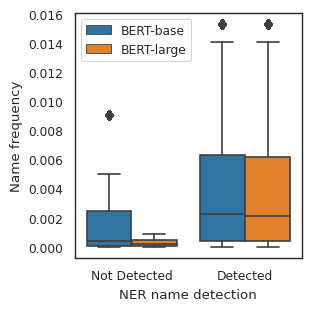

array(['A', 'Abd', 'Abu', 'Achilles', 'Adem', 'Ademide', 'Ademola',
       'Adler', 'Advait', 'Advay', 'Aeron', 'Aggelos', 'Ahad', 'Ahil',
       'Aj', 'Ajus', 'Akin', 'Al', 'Alaz', 'Albey', 'Albion', 'Alborz',
       'Albus', 'Aldous', 'Aled', 'Alessio', 'Alexandre', 'Alfred',
       'Alfredo', 'Alias', 'Alp', 'Alpha', 'Alteo', 'Amar', 'Amare',
       'Amarii', 'Amen', 'An', 'Anant', 'Anay', 'Andreas', 'Andrei',
       'Anvit', 'Arad', 'Arbor', 'Archit', 'Aren', 'Arion', 'Arsh',
       'Artemis', 'Arth', 'Arthor', 'Artiom', 'Artyom', 'Arush', 'Aryan',
       'Asha', 'Aspen', 'Aston', 'Ates', 'Atharv', 'Atharva', 'Atlas',
       'Atticus', 'August', 'Augustas', 'Auguste', 'Augustin',
       'Augustine', 'Augustus', 'Aun', 'Aven', 'Awais', 'Aws', 'Ayad',
       'Ayen', 'Baby', 'Bailee', 'Bam', 'Banks', 'Barclay', 'Basem',
       'Baz', 'Beaumont', 'Beaux', 'Bela', 'Bence', 'Benediktas',
       'Benicio', 'Benson', 'Bentley', 'Bernard', 'Bernardo', 'Bless',
       'Blessing', 'Boston', '

In [20]:
results_df = pd.read_csv('data/ner_deep_learning_results.csv')

from scipy.stats import ttest_ind

for model in ner_models:
    results_df['y_pred'] = results_df['y_pred'].astype(int)
    a = results_df[(results_df['y_pred'] == 0) & (results_df['model'] == model)]['Population Percentage'].to_numpy()
    b = results_df[(results_df['y_pred'] == 1) & (results_df['model'] == model)]['Population Percentage'].to_numpy()
    print(f'model {model} ttest')
    r = ttest_ind(a, b, alternative='less')
    print(r)

results_df['y_pred'] = results_df['y_pred'].replace(1, 'Detected')
results_df['y_pred'] = results_df['y_pred'].replace(0, 'Not Detected')

results_df2 = results_df.copy()
results_df2['model'] = results_df2['model'].replace('dslim/bert-base-NER', 'BERT-base')
results_df2['model'] = results_df2['model'].replace('dslim/bert-large-NER', 'BERT-large')

plt.figure(figsize=(3, 3), constrained_layout=True)
sns.boxplot(data=results_df2, x="y_pred", y="Population Percentage", hue='model')
plt.xlabel('NER name detection')
plt.ylabel('Name frequency')
plt.savefig('figures/ner.pdf')
plt.legend(loc='upper left')
plt.show()

x = results_df.groupby('y_pred')["Population Percentage"].mean()

mistakes = results_df[results_df['y_pred'] == 'Not Detected']['Name'].unique()
mistakes

                  firstname     obs  pcthispanic  pctwhite  pctblack  pctapi  \
0                     AARON    3646        2.880    91.607     3.264   2.057   
1                     ABBAS      59        0.000    71.186     3.390  25.424   
2                     ABBEY      57        0.000    96.491     3.509   0.000   
3                     ABBIE      74        1.351    95.946     2.703   0.000   
4                      ABBY     262        1.527    94.656     1.527   2.290   
...                     ...     ...          ...       ...       ...     ...   
4246                  ZOFIA      55        0.000   100.000     0.000   0.000   
4247                  ZOILA      66       86.364    12.121     1.515   0.000   
4248                 ZOLTAN      47        6.383    87.234     4.255   2.128   
4249                  ZORAN      52        0.000   100.000     0.000   0.000   
4250  ALL OTHER FIRST NAMES  214124        8.226    51.422    11.541  28.117   

      pctaian  pct2prace  
0       0.05

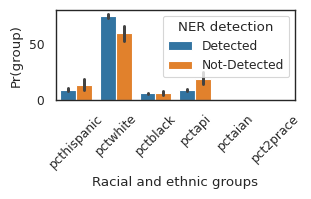

In [213]:
df_mistakes = pd.DataFrame({
    'firstname': results_df[(results_df['y_pred'] == 'Not Detected') & (results_df['model'] == 'dslim/bert-base-NER')]['Name'].unique()
})

df_correct = pd.DataFrame({
    'firstname': results_df[(results_df['y_pred'] == 'Detected') & (results_df['model'] == 'dslim/bert-base-NER')]['Name'].unique()
})

df_correct['firstname'] = df_correct['firstname'].str.upper()
df_mistakes['firstname'] = df_mistakes['firstname'].str.upper()

ethnicity_estimates = pd.read_csv('data/firstnames.csv')

# mistakes

# https://github.com/appeler/ethnicolr/blob/master/ethnicolr/data/census/census_2000.pdf
# page 17

groups = [
    'pcthispanic', # percent hispanic origin
    'pctwhite', # percent non-hispanic white only
    'pctblack', # perecnet non-hispanic black only
    'pctapi', # Percent non-hispanic Asian and pacific islander only
    'pctaian', # Percent non-hispanic american indian and alaskan native only
    'pct2prace' # Percent non-hispanic of two or more races
]

print(ethnicity_estimates)

df_mistake_ethnicity = df_mistakes.merge(ethnicity_estimates, on='firstname', how='inner')
print('mistake intersection')
print(df_mistake_ethnicity)

df_ref_ethnicity = df_correct.merge(ethnicity_estimates, on='firstname', how='inner')
print('correct intersection')
print(df_ref_ethnicity)

probs = [df_mistake_ethnicity[group] for group in groups]
ethnicity = [[group] * len(df_mistake_ethnicity[group]) for group in groups]
probs = np.concatenate(probs, axis=0)
ethnicity = np.concatenate(ethnicity, axis=0)

df_prob = pd.DataFrame({
    'prob': probs,
    'ethnicity': ethnicity,
    'NER detection': ['Not-Detected'] * len(probs)
})

# general
probs = [df_ref_ethnicity[group] for group in groups]
ethnicity = [[group] * len(df_ref_ethnicity[group]) for group in groups]
probs = np.concatenate(probs, axis=0)
ethnicity = np.concatenate(ethnicity, axis=0)

df_prob_pop = pd.DataFrame({
    'prob': probs,
    'ethnicity': ethnicity,
    'NER detection': ['Detected'] * len(probs)
})

df_sets = pd.concat([df_prob_pop, df_prob]).reset_index(drop=True)

plt.figure(figsize=(3,3/1.6), constrained_layout=True)
ax = sns.barplot(data=df_sets, y='prob', x='ethnicity', hue='NER detection')

plt.xticks(rotation=45)
plt.xlabel('Racial and ethnic groups')
plt.ylabel(r'Pr(group)')
plt.savefig('figures/raceethnic-bias.pdf')
plt.show()
